In [ ]:
#pip install -q tfds-nightly tensorflow matplotlib
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
# pip install tensorflow-hub

In [ ]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-hub

In [16]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Imports pour le modèle de Régression Logistique et Forets Aleatoires:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# import spacy
# import nltk
# import string
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.probability import FreqDist
# nltk.download('popular')
# nltk.download('stopwords')

In [ ]:
#imports our le modèle RNN (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#imports pour le modèle Transfer Learning avec Tensorflow Hub
import tensorflow_hub as hub
import os
#from tensorflow.keras import layers
import tf_keras # as keras

#Chargement du dataset

In [ ]:
# Charger le dataset IMDB via TensorFlow
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Diviser le dataset en train et test
train_dataset, test_dataset = dataset['train'], dataset['test']


#Exploration des données

In [ ]:

# Fonction pour convertir un tf.data.Dataset en DataFrame pandas
def dataset_to_dataframe(dataset):
    # Liste pour stocker les critiques et les sentiments
    reviews = []
    sentiments = []

    # Iterer sur les exemples du dataset TensorFlow
    for review, sentiment in tfds.as_numpy(dataset):  # Convertir en numpy pour pouvoir manipuler facilement
        reviews.append(review.decode('utf-8'))  # Convertir les bytes en string
        sentiments.append(int(sentiment))  # Convertir le label en int

    # Créer un DataFrame pandas avec deux colonnes : 'critique' et 'sentiment'
    df = pd.DataFrame({'critique': reviews, 'sentiment': sentiments})
    return df

# Convertir le dataset d'entraînement en DataFrame pandas
train_df = dataset_to_dataframe(train_dataset)

# Convertir le dataset de test en DataFrame pandas
test_df = dataset_to_dataframe(test_dataset)

# Afficher les premières lignes pour vérifier
display(train_df.head())


,critique,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   critique   25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   critique   25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
train_df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Remarque: Les classes sont équilibrés (autant de critiques positives que négatives)

In [ ]:
train_df['critique'].duplicated().sum()

96

## Longueur des critiques

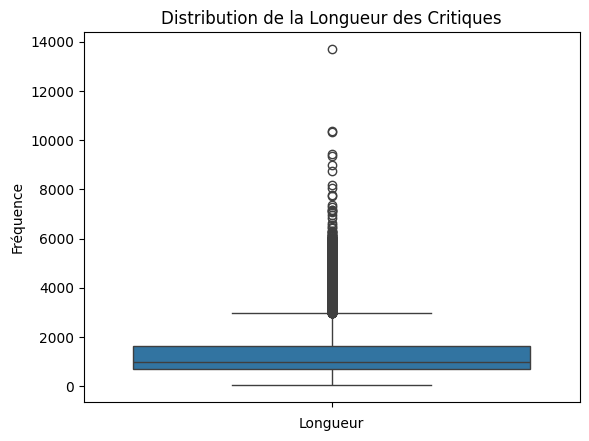

In [ ]:
sentence_lengths = [len(sentence) for sentence in train_df['critique']]
sorted_lengths = sorted(sentence_lengths)
sns.boxplot(sorted_lengths)
plt.title('Distribution de la Longueur des Critiques')
plt.xlabel('Longueur')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
#Afficher la mediane, le min et le max
print('Moyenne:', np.mean(sentence_lengths))
print('Mediane:', np.median(sentence_lengths))
print('Min:', np.min(sentence_lengths))
print('Max:', np.max(sentence_lengths))

#Afficher les quartiles du boxplot
Q1 = np.percentile(sentence_lengths, 25)
Q3 = np.percentile(sentence_lengths, 75)
print('Q1:', Q1)
print('Q3:', Q3)

Moyenne: 1325.06964
Mediane: 979.0
Min: 52
Max: 13704
Q1: 702.0
Q3: 1614.0


La moitié des critiques ont une logueur autour de 980 caracteres.
Un quart des critiques ont une longueur inférieure à 700 cractères.

#Approche 1A: Régression Logistique

##Test avec pré-traitement manuel


In [ ]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Initialiser stopwords et lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Dictionnaire de contractions (ajustez selon vos besoins)
contraction_map = {
    "don't": "do not", "won't": "will not", "can't": "cannot", "it's": "it is", "i'm": "i am"
}

def preprocess_text(text):
    # Remplacer les contractions
    for contraction, full_form in contraction_map.items():
        text = text.replace(contraction, full_form)

    # Convertir en minuscules
    text = text.lower()

    # Supprimer les balises HTML comme <br>
    text = re.sub(r'<.*?>', '', text)  # Supprime tout ce qui ressemble à une balise HTML

    # Supprimer la ponctuation (garder les points d'exclamation pour l'intensité)
    text = re.sub(r'[^a-z\s!]', '', text)

    # Tokenisation (split par espace)
    tokens = text.split()

    # Suppression des stopwords et lemmatisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Joindre les tokens en une chaîne de texte
    return ' '.join(tokens)


###########@
#  Appliquer le prétraitement sur toutes les critiques
# Utiliser tqdm pour suivre la progression de l'application de la fonction preprocess_text
tqdm.pandas()  # Intégrer tqdm à pandas

train_df['cleaned_critique'] = train_df['critique'].progress_apply(preprocess_text)
test_df['cleaned_critique'] = test_df['critique'].progress_apply(preprocess_text)

#  Utilisation de TfidfVectorizer pour transformer le texte en une matrice TF-IDF
tfidf = TfidfVectorizer(max_features=5000)  # Limiter le nombre de caractéristiques

#  Pipeline pour vectorisation + régression logistique
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(penalty='l2', solver='liblinear'))  # Modèle avec régularisation L2
])
# Séparer les données en X (les critiques) et y (les sentiments)
X_train = train_df['cleaned_critique']
y_train = train_df['sentiment']

X_test = test_df['cleaned_critique']
y_test = test_df['sentiment']
#  Entraîner le modèle
pipeline.fit(X_train, y_train)

#  Prédictions sur les données de test
y_pred = pipeline.predict(X_test)

#  Évaluation du modèle
print(classification_report(y_test, y_pred))


100%|██████████| 25000/25000 [00:16<00:00, 1541.71it/s]


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [ ]:

# Scores d'entraînement et de test
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Score en entraînement: {train_score:.5f}")
print(f"Score en test: {test_score:.5f}")

Score en entraînement: 0.91292
Score en test: 0.87748


### Scores du modèle après gridsearcv pour la régulation

In [ ]:
#TEST de gridsearchCV

# Définir les valeurs de C à tester (grande variété pour ajuster la régulation)
param_grid = {'logreg__C': [0.5,1, 1.5,2, 3, 4]}

# Appliquer la fonction de recherche des meilleurs paramètres
best_model = grid_search_logistic_regression(X_train, y_train, param_grid)

# Évaluer les performances sur le set de test

best_model_score = best_model.score(X_test, y_test)
print("Score en Test avec best_model_score :", best_model_score)

Meilleure valeur de C : 1.5
Meilleur score de validation croisée : 0.8797200000000001
Score en Test avec best_model_score : 0.87668


### Visualisation des mots les plus fréquents

In [ ]:
# On crée un df global
df = pd.concat([train_df, test_df])

# On rassembler les mots du dataframe en 3 groupes : tout, pos, nég
mots = " ".join(df['cleaned_critique'])
mots_negatifs = " ".join(df[df["sentiment"] == 0].cleaned_critique)
mots_positifs = " ".join(df[df["sentiment"] == 1].cleaned_critique)

In [ ]:
df.head()

,critique,sentiment,cleaned_critique
0,This was an absolutely terrible movie. Don't b...,0,absolutely terrible movie dont lured christoph...
1,"I have been known to fall asleep during films,...",0,known fall asleep film usually due combination...
2,Mann photographs the Alberta Rocky Mountains i...,0,mann photograph alberta rocky mountain superb ...
3,This is the kind of film for a snowy Sunday af...,1,kind film snowy sunday afternoon rest world go...
4,"As others have mentioned, all the women that g...",1,others mentioned woman go nude film mostly abs...


In [ ]:
import seaborn as sns
from nltk.tokenize import word_tokenize # import word_tokenize
from nltk import FreqDist
nltk.download('punkt') # download punkt sentence tokenizer

#fonction d'affichage d'un histogramme avec la fréquence des mots
def afficher_hist(mots,titre):
  mots_tokens = word_tokenize(mots.lower())
  freq = FreqDist(mots_tokens)
  mots_20 = freq.most_common(20)
  mots_20 = pd.Series(dict(mots_20))

  plt.figure(figsize=(10,5))
  sns.barplot(x = mots_20.index, y=mots_20.values)
  plt.xticks(rotation = 45)
  plt.title(titre)
  plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


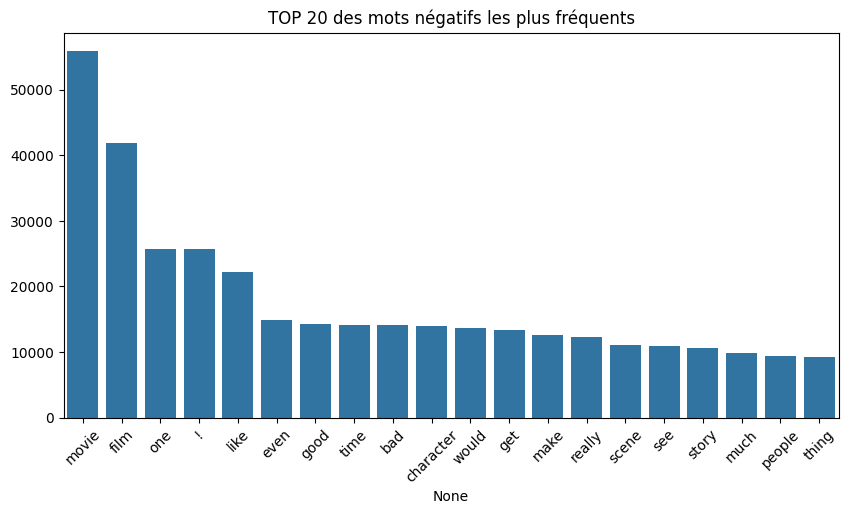

In [ ]:
#Afficher le graph pour les mots négatifs
afficher_hist(mots_negatifs,"TOP 20 des mots négatifs les plus fréquents")

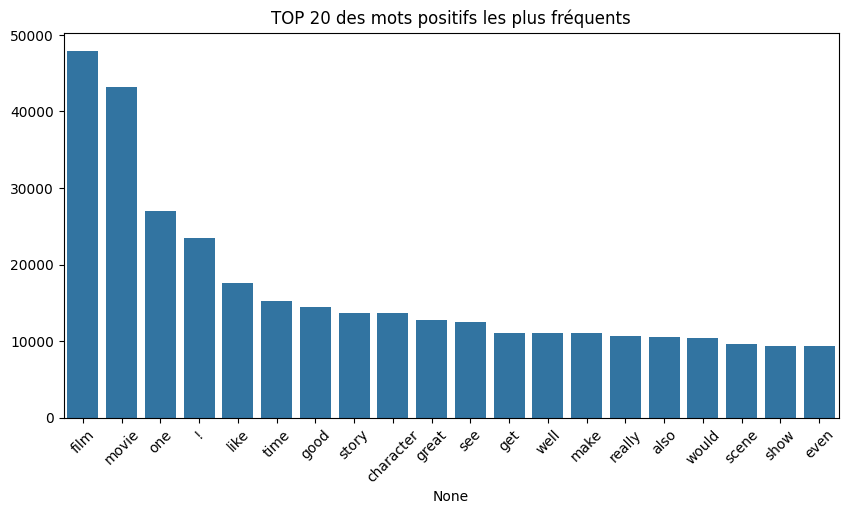

In [ ]:
# Afficher le graph pour les mots positifs
afficher_hist(mots_positifs,"TOP 20 des mots positifs les plus fréquents")

Même si les mots les plus fréquents dans les critiques négatives et positives se ressemblent, le modèle montrent une très bonne performance plus classer les deux types de critiques (88%)

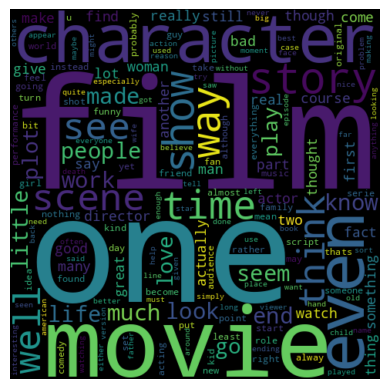

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=480, height=480, max_font_size=200, min_font_size=10)

text = mots

# Génération du wordcloud depuis un texte
wordcloud.generate_from_text(text)

# Affichage grâce à Matplotlib
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Test Sans Pré-traitement

In [ ]:
# Juste tf-idf avec limitation

# Séparer les données en X (les critiques) et y (les sentiments)
X_train = train_df['critique']
y_train = train_df['sentiment']

X_test = test_df['critique']
y_test = test_df['sentiment']

# Transformer les critiques en matrices TF-IDF
# Tout en limitant à 5000 le nombre de mots les plus frequents (pour réduire la complexité/taille du vocabulaire)
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Entraîner une régression logistique
model_Logistic_R = LogisticRegression()
model_Logistic_R.fit(X_train_tfidf, y_train)

# Prédictions sur le set de test
y_pred = model_Logistic_R.predict(X_test_tfidf)

# Évaluer la performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [ ]:
# Afficher le score pour l'entrainement
 #(avant d'avoir ajouté les options stopwords et lower a tf-idf)
print("Score d'entraînement",model_Logistic_R.score(X_train_tfidf, y_train))
print("Score de test",model_Logistic_R.score(X_test_tfidf, y_test))

Score d'entraînement 0.91372
Score de test 0.88252


###Résultats avec options TF-IDF: stop_words='english', lowercase=True

In [ ]:
# TEST avec: stop_words='english', lowercase=True

# Transformer les critiques en matrices TF-IDF, en eliminant les stopwords, et le majuscules
# Tout en limitant à 5000 le nombre de mots les plus frequents (pour réduire la complexité/taille du vocabulaire)
tfidf = TfidfVectorizer(max_features=5000,stop_words='english', lowercase=True)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Entraîner une régression logistique
model_Logistic_R = LogisticRegression()
model_Logistic_R.fit(X_train_tfidf, y_train)

# Prédictions sur le set de test
y_pred = model_Logistic_R.predict(X_test_tfidf)

# Évaluer la performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [ ]:
# Afficher le score pour l'entrainement avec stop_words='english', lowercase=True
print("Avec options tf-idf(stop_words='english', lowercase=True)")
print("Score d'entraînement : ",model_Logistic_R.score(X_train_tfidf, y_train))
print("Score de test : ",model_Logistic_R.score(X_test_tfidf, y_test))

Avec options tf-idf(stop_words='english', lowercase=True)
Score d'entraînement :  0.91588
Score de test :  0.87832


Le resultat semble légèrement moins bon avec les options stop_words='english', lowercase=True.

Un peu plus d'overfitting, et baisse du score de test

Remarques:

Le score de test est plus faible que le score d'entraînement. Il y a donc un leger overfitting (surentraînement).
Cela pourrait devenir plus problématique avec des dritiques moins "polarisées" que celles proposées dans le dataset courant.

Nous pouvons donc ajouter une régularisation.
Dans ce projet, toutes les critiques de films sont représentées avec une grande variété de mots, et il n’est pas évident de penser qu’il faille éliminer certains mots complètement. La régularisation L2 permet de réduire l’impact des mots sans en éliminer certains totalement (contrairement à L1)

## Ajout de la régularisation L2

In [ ]:

# Entraînement du modèle avec régularisation L2 (paramètre par défaut)
model_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')  # C = 1.0 par défaut

# Entraîner le modèle
model_l2.fit(X_train_tfidf, y_train)

# Évaluer sur les données de test
y_pred_l2 = model_l2.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_l2))

# Afficher le score d'entraînement et de test
print("Score en entraînement :", model_l2.score(X_train_tfidf, y_train))
print("Score en test :", model_l2.score(X_test_tfidf, y_test))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Score en entraînement : 0.91596
Score en test : 0.87824


Le score de test augmente légérement avec C=1 pour la régularisation L2

## Optimisation GridSearchCV

### Fonction grid_search_logistic_regression

In [ ]:
# Pour trouver la meilleure valeur de la regularisation (hyperparamètre C)
# On applique une validation GridSearchCV

def grid_search_logistic_regression(X, y, param_grid):
  # Créer une pipeline combinant TF-IDF et la régression logistique
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=5000)),  # Limiter à 5000 caractéristiques
      ('logreg', LogisticRegression(penalty='l2', solver='liblinear'))  # Régularisation L2
  ])

  # Appliquer GridSearchCV avec 5-fold cross-validation
  grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

  # Entraîner GridSearchCV sur les données d'entraînement
  grid_search.fit(X, y)

  # Afficher la meilleure valeur de C
  print("Meilleure valeur de C :", grid_search.best_params_['logreg__C'])

  # Meilleur score obtenu avec cette valeur de C
  print("Meilleur score de validation croisée :", grid_search.best_score_)

  # # Évaluer les performances sur le set de test
  # best_model = grid_search.best_estimator_
  # best_model_score = best_model.score(X_test, y_test)
  # print("Score best_model_score :", best_model_score)
  return grid_search.best_estimator_

### Recherche du meilleur C

In [ ]:
# Définir les valeurs de C à tester (grande variété pour ajuster la régularisation)
param_grid = {'logreg__C': [0.01, 0.1, 1, 10, 100]}

# Appliquer la fonction de recherche des meilleurs paramètres
grid_search_logistic_regression(X_train, y_train, param_grid)


Meilleure valeur de C : 1
Meilleur score de validation croisée : 0.8827999999999999


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('logreg', LogisticRegression(C=1, solver='liblinear'))])

In [ ]:
#TEST de gridsearchCV avec un intervalle different pour C

# Définir les valeurs de C à tester (grande variété pour ajuster la régularisation)
param_grid = {'logreg__C': [0.5,1, 1.5,2, 3, 4]}

# Appliquer la fonction de recherche des meilleurs paramètres
best_model = grid_search_logistic_regression(X_train, y_train, param_grid)

# Évaluer les performances sur le set de test

best_model_score = best_model.score(X_test, y_test)
print("Score de Test avec best_model_score :", best_model_score)

Meilleure valeur de C : 3
Meilleur score de validation croisée : 0.8862400000000001
Score de Test avec best_model_score : 0.88232


In [ ]:
#afficher le rapport de classification
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



**Remarques :**:

Avec C= 3 trouvé en reserrant l'intervalle de variation dans GridSearchCV, il n'y a pratiquement plus de différence entre le train (0.88624) et le test ( 0.88232).

Par contre les techniques de lemmatization , élimination des stopwords , ainsi que la punctuation, n'ont pas vraiment amélioré les scores.

TF-IDF parait déjà suffisant pour ce dataset qui est très grand.

In [ ]:
# Pour trouver la meilleure valeur de la regularisation (hyperparamètre C)
# On applique une validation GridSearchCV

def grid_search_logistic_regression_preproc(X, y, param_grid):
  # Créer une pipeline combinant TF-IDF et la régression logistique
  pipeline = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=5000,stop_words='english', lowercase=True)),  # Limiter à 5000 caractéristiques
      ('logreg', LogisticRegression(penalty='l2', solver='liblinear'))  # Régularisation L2
  ])

  # Appliquer GridSearchCV avec 5-fold cross-validation
  grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

  # Entraîner GridSearchCV sur les données d'entraînement
  grid_search.fit(X, y)

  # Afficher la meilleure valeur de C
  print("Meilleure valeur de C :", grid_search.best_params_['logreg__C'])

  # Meilleur score obtenu avec cette valeur de C
  print("Meilleur score de validation croisée :", grid_search.best_score_)

  # # Évaluer les performances sur le set de test
  # best_model = grid_search.best_estimator_
  # best_model_score = best_model.score(X_test, y_test)
  # print("Score best_model_score :", best_model_score)
  return grid_search.best_estimator_

  #TEST de gridsearchCV avec un intervalle different pour C

# Définir les valeurs de C à tester (grande variété pour ajuster la régularisation)
param_grid = {'logreg__C': [1, 1.5,2,2.5, 3, 3.5]}

# Appliquer la fonction de recherche des meilleurs paramètres
best_model = grid_search_logistic_regression_preproc(X_train, y_train, param_grid)

# Évaluer les performances sur le set de test

best_model_score = best_model.score(X_test, y_test)
print("Score de Test avec tf-idf stopwords&lower options :", best_model_score)

Meilleure valeur de C : 2.5
Meilleur score de validation croisée : 0.881
Score de Test avec tf-idf stopwords&lower options : 0.8748


In [ ]:
#afficher le rapport de classification
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



# Approche 1B: Forêts Aléatoires

##Chargement et vectorisation TF-IDF des données

In [7]:
# Charger le dataset IMDB via TensorFlow
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Diviser le dataset en train et test
train_dataset, test_dataset = dataset['train'], dataset['test']

# Fonction pour convertir un tf.data.Dataset en DataFrame pandas
def dataset_to_dataframe(dataset):
    # Liste pour stocker les critiques et les sentiments
    reviews = []
    sentiments = []

    # Iterer sur les exemples du dataset TensorFlow
    for review, sentiment in tfds.as_numpy(dataset):  # Convertir en numpy pour pouvoir manipuler facilement
        reviews.append(review.decode('utf-8'))  # Convertir les bytes en string
        sentiments.append(int(sentiment))  # Convertir le label en int

    # Créer un DataFrame pandas avec deux colonnes : 'critique' et 'sentiment'
    df = pd.DataFrame({'critique': reviews, 'sentiment': sentiments})
    return df

# Convertir le dataset d'entraînement en DataFrame pandas
train_df = dataset_to_dataframe(train_dataset)

# Convertir le dataset de test en DataFrame pandas
test_df = dataset_to_dataframe(test_dataset)

# Afficher les premières lignes pour vérifier
display(train_df.head())

# Séparer les données en X (les critiques) et y (les sentiments)
X_train = train_df['critique']
y_train = train_df['sentiment']

X_test = test_df['critique']
y_test = test_df['sentiment']




,critique,sentiment
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [8]:
# Transformer les critiques en matrices TF-IDF
# Tout en limitant à 5000 le nombre de mots les plus frequents (pour réduire la complexité/taille du vocabulaire)
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Entrainement du modèle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#entrainer le modèle
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train_tfidf, y_train)


RandomForestClassifier(n_estimators=200)

In [ ]:
#prédiction sur les données de test
y_pred = clf.predict(X_test_tfidf)
accuracy = clf.score(X_test_tfidf,y_test)
print("Forêt aléatoire (200 arbres) train : " + str(clf.score(X_train_tfidf,y_train)))
print("Forêt aléatoire (200 arbres) test : " + str(clf.score(X_test_tfidf,y_test)))

Forêt aléatoire (200 arbres) train : 1.0
Forêt aléatoire (200 arbres) test : 0.84368


## Courbe accuracy vs n_estimators

10 0.7558
20 0.79532
30 0.80824
40 0.821
50 0.82608
60 0.83068
70 0.8364
80 0.83524
90 0.8368
100 0.83896
110 0.84196
120 0.84228
130 0.84088
140 0.84196
150 0.8414
160 0.84184
170 0.84544
180 0.84472
190 0.8446
200 0.84404
210 0.84564
220 0.84704
230 0.84388
240 0.84736
250 0.8464
260 0.84636
270 0.84564
280 0.84788
290 0.84688
300 0.84832


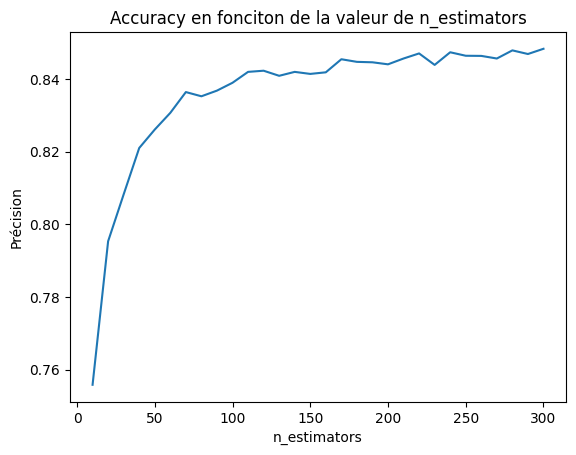

In [ ]:
N = 30
accuracy = []

for i in range(N):
    clf = RandomForestClassifier(n_estimators=(i+1)*10)
    clf.fit(X_train_tfidf, y_train)
    accuracy.append(clf.score(X_test_tfidf,y_test))
    print((i+1)*10, accuracy[i])

plt.plot([10*(i+1) for i in range(30)], accuracy)
plt.xlabel("n_estimators")
plt.ylabel("Précision")
plt.title("Accuracy en fonction de la valeur de n_estimators")
plt.show()

Notes: à partir d'environ 100 estimateurrs la croissance de la précision (Accuracy) ralenti et elle n'augmente pratiquement plus, on peut dire qu'elle se stabilise autour de 84 % au delà de 110 estimators.

## Optimisation

In [14]:
#parametres à tester
param_grid = {
    'n_estimators': [80, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

### GridSearchCV

In [23]:

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid,
                           )
grid_search.fit(X_train_tfidf, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9,
                       n_estimators=150)


In [24]:
#mise à jour du modèle avec les meilleurs parametres
model_grid = RandomForestClassifier( max_depth = grid_search.best_estimator_. max_depth,
                                     max_features = grid_search.best_estimator_. max_features,
                                     max_leaf_nodes = grid_search.best_estimator_. max_leaf_nodes,
                                     n_estimators = grid_search.best_estimator_. n_estimators
                                    )
model_grid.fit(X_train_tfidf, y_train)
y_pred_grid = model_grid.predict(X_test_tfidf)
print("Model grid: ",classification_report(y_pred_grid, y_test))


Model grid:                precision    recall  f1-score   support

           0       0.81      0.83      0.82     12084
           1       0.84      0.81      0.83     12916

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [25]:
print("Forêt aléatoire grid best train : " + str(model_grid.score(X_train_tfidf,y_train)))
print("Forêt aléatoire grid best test : " + str(model_grid.score(X_test_tfidf,y_test)))

Forêt aléatoire grid best train : 0.83908
Forêt aléatoire grid best test : 0.82304


In [26]:
print("Max depth :", grid_search.best_estimator_. max_depth)
print("Max features :", grid_search.best_estimator_. max_features)
print("Max leaf nodes :",grid_search.best_estimator_. max_leaf_nodes)
print("N estimators :", grid_search.best_estimator_. n_estimators)


Max depth : 9
Max features : log2
Max leaf nodes : 9
N estimators : 150


###RandomizedSearchCV

In [18]:

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train_tfidf, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_leaf_nodes=9)


In [27]:
print("Max depth :", random_search.best_estimator_. max_depth)
print("Max features :", random_search.best_estimator_. max_features)
print("Max leaf nodes :", random_search.best_estimator_. max_leaf_nodes)
print("N estimators :", random_search.best_estimator_. n_estimators)


Max depth : 9
Max features : sqrt
Max leaf nodes : 9
N estimators : 100


In [22]:
#construire le modele RandomForestClassifier avec les meilleurs parameters du best_estimator
model_random = RandomForestClassifier(
                                       max_depth= random_search.best_estimator_. max_depth,
                                       max_features = random_search.best_estimator_. max_features,
                                       max_leaf_nodes = random_search.best_estimator_. max_leaf_nodes,
                                       n_estimators= random_search.best_estimator_. n_estimators
              )
model_random.fit(X_train_tfidf, y_train)
y_pred_grid = model_random.predict(X_test_tfidf)
print(classification_report(y_pred_grid, y_test))
print("Forêt aléatoire random best train : " + str(model_random.score(X_train_tfidf,y_train)))
print("Forêt aléatoire random best test : " + str(model_random.score(X_test_tfidf,y_test)))


              precision    recall  f1-score   support

           0       0.77      0.83      0.80     11666
           1       0.84      0.79      0.81     13334

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Forêt aléatoire random best train : 0.81952
Forêt aléatoire random best test : 0.80824


# Approche 2: Deep Learning RNN

## 2A : RNN-GRU avec text vectorization

"The TensorFlow Text library also implements various tokenization strategies, including WordPiece8 (a variant of BPE), and last but not least, the Tokenizers library by Hugging Face implements a wide range of extremely fast tokenizers.

However, for the IMDb task in English, using spaces for token boundaries should be good enough. So let’s go ahead with creating a TextVectorization layer and adapting it to the training set. "

We limit the size of the vocabulary (number of words) in order to reduce the number of parameters the model needs to learn.

### Chargement des données

In [ ]:
raw_train_set, raw_valid_set, raw_test_set = tfds.load( name="imdb_reviews",
                                                        split=["train[:80%]", "train[80%:]", "test"],
                                                        as_supervised=True
                                                      )
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IWG7F_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IWG7F_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2IWG7F_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


### Couche Text Vectorization

In [ ]:
vocab_size = 5000
text_vec_layer = keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

### Entrainement

In [ ]:
#create the model and train it:
embed_size = 128
tf.random.set_seed(42)
model = keras.Sequential([
                            text_vec_layer,
                            keras.layers.Embedding(vocab_size, embed_size,mask_zero=True),
                            keras.layers.GRU(128),
                            keras.layers.Dense(1, activation="sigmoid")
                          ])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
625/625 [==============================] - 789s 1s/step - loss: 0.4581 - accuracy: 0.7767 - val_loss: 0.3327 - val_accuracy: 0.8626
Epoch 2/2
625/625 [==============================] - 893s 1s/step - loss: 0.3295 - accuracy: 0.8579 - val_loss: 0.3163 - val_accuracy: 0.8654


###Evaluation

In [ ]:
# Évaluer sur le test set

test_loss, test_acc = model.evaluate(test_set)
print(f'Test Accuracy: {test_acc}')

782/782 [==============================] - 200s 255ms/step - loss: 0.3137 - accuracy: 0.8719
Test Accuracy: 0.8718799948692322


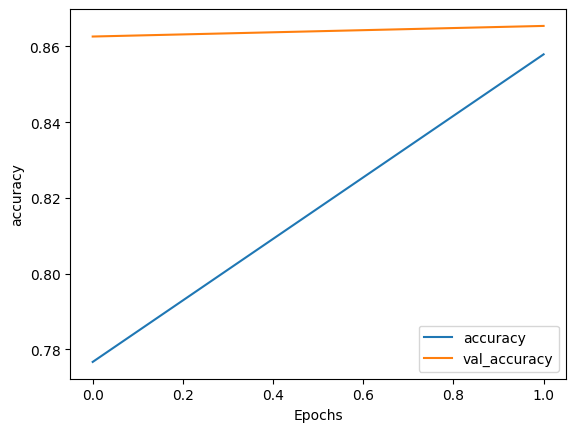

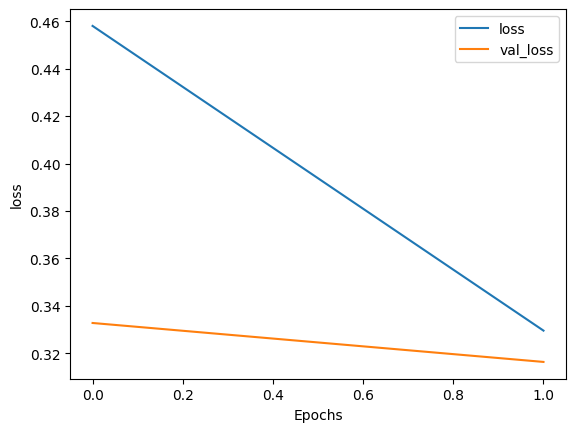

In [ ]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

plot_history(history, "accuracy")
plot_history(history, "loss")

### Optim Keras Tuner

In [ ]:
import keras_tuner as kt
import keras

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # Add the TextVectorization layer (pre-adapted)
    model.add(text_vec_layer)

    # Embedding layer with reduced range for size
    embed_size = hp.Int('embedding_dim', min_value=64, max_value=128, step=32)  # Narrow range
    model.add(keras.layers.Embedding(vocab_size, embed_size, mask_zero=True))

    # GRU layer with a reduced range for units
    units = hp.Int('gru_units', min_value=64, max_value=128, step=32)  # Narrow range
    model.add(keras.layers.GRU(units))

    # Dense output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model with a reduced range for learning rate
    model.compile(
        optimizer=keras.optimizers.Nadam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')),  # Narrow range
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up the RandomSearch tuner with fewer trials
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,  # Reduced number of trials
    executions_per_trial=1,
    overwrite=True,
    directory='my_tuning_dir',
    project_name='gru_hyperparameter_tuning'
)

# Perform the search for the best hyperparameters with reduced epochs
tuner.search(train_set, validation_data=valid_set, epochs=3)  # Fewer epochs during search

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hp.values}")

## Rebuild and train the model with the best hyperparameters
#best_model = tuner.hypermodel.build(best_hp)
#history = best_model.fit(train_set, validation_data=valid_set, epochs=best_hp.get('epochs'))  # Adjust epochs

## Evaluate the model on the test set
#test_loss, test_acc = best_model.evaluate(test_set)
#print(f"Test accuracy: {test_acc}")


Trial 4 Complete [00h 44m 11s]
val_accuracy: 0.8745999932289124

Best val_accuracy So Far: 0.883400022983551
Total elapsed time: 02h 21m 22s
Best Hyperparameters: {'embedding_dim': 64, 'gru_units': 64, 'learning_rate': 0.00021669207674046597}


TypeError: HyperParameters.get() takes 2 positional arguments but 3 were given

#### Evaluation du best model avec 3 epochs

In [ ]:
#Trial 4 Complete [00h 44m 11s]
#val_accuracy: 0.8745999932289124

#Best val_accuracy So Far: 0.883400022983551
#Total elapsed time: 02h 21m 22s
#Best Hyperparameters: {'embedding_dim': 64,
#'gru_units': 64, 'learning_rate': 0.00021669207674046597}
## Rebuild and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(train_set, validation_data=valid_set, epochs=3)  # Adjust epochs

## Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 494s 783ms/step - accuracy: 0.6136 - loss: 0.6229 - val_accuracy: 0.8734 - val_loss: 0.3185
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 468s 728ms/step - accuracy: 0.8823 - loss: 0.2917 - val_accuracy: 0.8846 - val_loss: 0.2981
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 497s 721ms/step - accuracy: 0.9136 - loss: 0.2313 - val_accuracy: 0.8708 - val_loss: 0.3422
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 161ms/step - accuracy: 0.8589 - loss: 0.3622
Test accuracy: 0.860480010509491


#### Evaluation du best model avec 2 epochs

In [ ]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(train_set, validation_data=valid_set, epochs=2)  # Adjust epochs

## Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 453s 717ms/step - accuracy: 0.6153 - loss: 0.6319 - val_accuracy: 0.8476 - val_loss: 0.3463
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 449s 719ms/step - accuracy: 0.8775 - loss: 0.2955 - val_accuracy: 0.8758 - val_loss: 0.2956
782/782 ━━━━━━━━━━━━━━━━━━━━ 98s 125ms/step - accuracy: 0.8769 - loss: 0.2975
Test accuracy: 0.877560019493103


## 2B: RNN-LSTM avec Tokenizer

In [1]:
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#imports pour le modèle RNN (LSTM)

#from tensorflow import keras
import tf_keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

###Chargement des données

In [2]:
#Charger les données
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Diviser le dataset en train et test
train_dataset, test_dataset = dataset['train'], dataset['test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DKVOF1_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DKVOF1_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DKVOF1_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


### Pré-traitement

In [3]:
# Paramètres pour la tokenization
vocab_size = 5000  # Max de mots les plus fréquents
max_length = 100    # Longueur des séquences
trunc_type = 'post'  # Si séquence plus longue, couper à la fin
padding_type = 'post'  # Si séquence trop courte padding 0 à la fin

# Créer un tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Extraire les textes des critiques (en chaines de caractères et les labels
train_sentences = []
train_labels = []

for review, label in train_dataset:
    train_sentences.append(str(review.numpy()))
    train_labels.append(label.numpy())

test_sentences = []
test_labels = []

for review, label in test_dataset:
    test_sentences.append(str(review.numpy()))
    test_labels.append(label.numpy())

# Adapter le tokenizer sur les textes d'entraînement
tokenizer.fit_on_texts(train_sentences)

# Convertir les textes en séquences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Appliquer le padding pour que toutes les séquences aient la même longueur
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding=padding_type, truncating=trunc_type)

#Split des données d'entrainement en 80% train et 20% validation
train_padded, validation_padded, y_train, y_valid = train_test_split(train_padded,
                                                                        train_labels, test_size=0.2,
                                                                        random_state=42)
train_padded = np.array(train_padded)
train_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

print(f'Train: {train_padded.shape}')
print(f'Validation: {validation_padded.shape}')
print(f'Test : {test_padded.shape}')


Train: (20000, 100)
Validation: (5000, 100)
Test : (25000, 100)


###Construction du modèle

In [ ]:
embedding_dim = 128 #round(vocab_size ** 0.25) # use the fourth root of the vocab size
units = 128
dropout = 0.25
def create_model(vocab_size, embedding_dim, units, dropout):
    model = keras.Sequential([
            keras.layers.Embedding(vocab_size, embedding_dim),  # Embedding layer
            keras.layers.LSTM(units),  # LSTM layer instead of GlobalAveragePooling1D
            keras.layers.Dropout(dropout),  # Dropout for regularization
            keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
        ])

    #adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=['accuracy'])

    return model

model = create_model(vocab_size, embedding_dim,units,dropout)
# Afficher la structure du modèle
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###Entrainement et évaluation

In [ ]:
# Entraîner le modèle
history = model.fit(train_padded, train_labels, epochs=10,
                    validation_data=(validation_padded, validation_labels), batch_size=64)


Epoch 1/10
313/313 [==============================] - 102s 314ms/step - loss: 0.5267 - accuracy: 0.7135 - val_loss: 0.4239 - val_accuracy: 0.8092
Epoch 2/10
313/313 [==============================] - 118s 377ms/step - loss: 0.3498 - accuracy: 0.8535 - val_loss: 0.4060 - val_accuracy: 0.8214
Epoch 3/10
313/313 [==============================] - 94s 299ms/step - loss: 0.2935 - accuracy: 0.8796 - val_loss: 0.4227 - val_accuracy: 0.8250
Epoch 4/10
313/313 [==============================] - 99s 317ms/step - loss: 0.2388 - accuracy: 0.9049 - val_loss: 0.4875 - val_accuracy: 0.8192
Epoch 5/10
313/313 [==============================] - 99s 315ms/step - loss: 0.1975 - accuracy: 0.9237 - val_loss: 0.4826 - val_accuracy: 0.8030
Epoch 6/10
313/313 [==============================] - 88s 282ms/step - loss: 0.1552 - accuracy: 0.9420 - val_loss: 0.5602 - val_accuracy: 0.7958
Epoch 7/10
313/313 [==============================] - 89s 285ms/step - loss: 0.1291 - accuracy: 0.9542 - val_loss: 0.6528 - val_

A partir de 3 epochs la précision de validation baisse

In [ ]:
from sklearn.metrics import classification_report

# Évaluer les performances sur les données de test
test_loss, test_acc = model.evaluate(test_padded, test_labels)

print(f"Test Accuracy: {test_acc:.4f}")

#afficher le rapport de classification

predictions = (model.predict(test_padded) > 0.5).astype("int32")

print(classification_report(test_labels, predictions))


782/782 [==============================] - 78s 99ms/step - loss: 0.9617 - accuracy: 0.7871
Test Accuracy: 0.7871
782/782 [==============================] - 62s 79ms/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     12500
           1       0.78      0.79      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



###Ajuster le nombre d'épochs à 3

In [ ]:
embedding_dim = 128 #round(vocab_size ** 0.25) # use the fourth root of the vocab size
units = 128
dropout = 0.25
def create_model(vocab_size, embedding_dim, units, dropout):
    model = keras.Sequential([
            keras.layers.Embedding(vocab_size, embedding_dim),  # Embedding layer
            keras.layers.LSTM(units),  # LSTM layer instead of GlobalAveragePooling1D
            keras.layers.Dropout(dropout),  # Dropout for regularization
            keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
        ])

    model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=['accuracy'])

    return model

model = create_model(vocab_size, embedding_dim,units,dropout)
# Afficher la structure du modèle
model.summary()


# Ajuster le nombre d'epochs
history = model.fit(train_padded, train_labels, epochs=3,
                    validation_data=(validation_padded, validation_labels), batch_size=64)

# Évaluer les performances sur les données de test
test_loss, test_acc = model.evaluate(test_padded, test_labels)

print(f"Test Accuracy 3 epochs: {test_acc:.4f}")

#afficher le rapport de classification

predictions = (model.predict(test_padded) > 0.5).astype("int32")

print(classification_report(test_labels, predictions))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 275ms/step - accuracy: 0.5978 - loss: 0.6412 - val_accuracy: 0.7942 - val_loss: 0.4662
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 291ms/step - accuracy: 0.8178 - loss: 0.4236 - val_accuracy: 0.8000 - val_loss: 0.4302
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - accuracy: 0.8328 - loss: 0.3916 - val_accuracy: 0.8188 - val_loss: 0.4141
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.7955 - loss: 0.4493
Test Accuracy 3 epochs: 0.7952
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     12500
           1       0.81      0.76      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



###Optimisation avec Keras Tuner

In [ ]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import keras

# Définir une fonction pour construire le modèle avec des hyperparamètres à ajuster
def build_model(hp):
    model = keras.Sequential()

    # Embedding Layer
    model.add(keras.layers.Embedding(
        input_dim=vocab_size+1,  # Taille du vocabulaire
        output_dim=hp.Int('embedding_dim', min_value=16, max_value=128, step=16)  # Taille de l'embedding à ajuster
    ))

    # LSTM Layer instead of Global Average Pooling
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),  # Tuning LSTM units
        return_sequences=False  # If you want to pass the final output of LSTM, not all outputs
    ))

    # Dense Layer
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu',
    ))

    # Dropout Layer
    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compilation
    model.compile(optimizer='nadam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Définir la recherche d'hyperparamètres avec Random Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimiser l'accuracy sur les données de validation
    max_trials=10,  # Nombre d'essais pour la recherche
    executions_per_trial=2,  # Nombre d'exécutions pour chaque essai
    overwrite=True,
    directory='my_dir',  # Répertoire où enregistrer les résultats
    project_name='hyperparameter_tuning'
)

# Rechercher les meilleurs hyperparamètres
tuner.search(train_padded, train_labels,
             epochs=5,
             validation_data=(validation_padded, validation_labels),
             batch_size=64)

# Obtenir les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]
print(f"Best LSTM Hyperparameters: {best_hp.values}")


Trial 10 Complete [00h 13m 06s]
val_accuracy: 0.8154999911785126

Best val_accuracy So Far: 0.8211000263690948
Total elapsed time: 01h 22m 07s
Best LSTM Hyperparameters: {'embedding_dim': 128, 'lstm_units': 32, 'dense_units': 80, 'dropout': 0.2}


###Créer le meilleur modèle

In [ ]:
# Extract the best hyperparameters - Keep 5 epochs
best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
best_model = keras.Sequential()

# Embedding Layer
best_model.add(keras.layers.Embedding(
    input_dim=vocab_size+1,
    output_dim=best_hp.get('embedding_dim')  # Use the best embedding dimension found
))

# LSTM Layer
best_model.add(keras.layers.LSTM(
    units=best_hp.get('lstm_units')  # Use the best LSTM units found
))

# Dense Layer
best_model.add(keras.layers.Dense(
    units=best_hp.get('dense_units'),
    activation='relu'
))

# Dropout Layer
best_model.add(keras.layers.Dropout(rate=best_hp.get('dropout')))

# Output Layer
best_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary_crossentropy loss
best_model.compile(optimizer='nadam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train the model on the full training set
history = best_model.fit(train_padded, train_labels,
                         epochs=5,  # You can choose the best number of epochs
                         validation_data=(validation_padded, validation_labels),
                         batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.6488 - loss: 0.5944 - val_accuracy: 0.8152 - val_loss: 0.4179
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8456 - loss: 0.3675 - val_accuracy: 0.8218 - val_loss: 0.4186
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.8712 - loss: 0.3056 - val_accuracy: 0.8126 - val_loss: 0.4934
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.8928 - loss: 0.2680 - val_accuracy: 0.8134 - val_loss: 0.5138
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9142 - loss: 0.2236 - val_accuracy: 0.8046 - val_loss: 0.6119
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7858 - loss: 0.6745
Test Loss: 0.675598680973053
Test Accuracy: 0.7874400019645691


### Ajuster le nb d'epochs à 3 pour Best Model

In [4]:
best_hp = {'embedding_dim': 128, 'lstm_units': 32, 'dense_units': 80, 'dropout': 0.2}

In [5]:
# Diminuons le nombre d'epochs à 3
best_nb_epochs = 3

# Extract the best hyperparameters
#best_hp = tuner.get_best_hyperparameters()[0]

# Build the model with the best hyperparameters
best_model = keras.Sequential()

# Embedding Layer
best_model.add(keras.layers.Embedding(
    input_dim=vocab_size+1,
    output_dim=best_hp.get('embedding_dim')  # Use the best embedding dimension found
))

# LSTM Layer
best_model.add(keras.layers.LSTM(
    units=best_hp.get('lstm_units')  # Use the best LSTM units found
))

# Dense Layer
best_model.add(keras.layers.Dense(
    units=best_hp.get('dense_units'),
    activation='relu'
))

# Dropout Layer
best_model.add(keras.layers.Dropout(rate=best_hp.get('dropout')))

# Output Layer
best_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary_crossentropy loss
best_model.compile(optimizer='nadam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train the model on the full training set
history = best_model.fit(train_padded, train_labels,
                         epochs=best_nb_epochs,
                         validation_data=(validation_padded, validation_labels),
                         batch_size=64)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/3
313/313 [==============================] - 32s 90ms/step - loss: 0.5121 - accuracy: 0.7322 - val_loss: 0.4121 - val_accuracy: 0.8160
Epoch 2/3
313/313 [==============================] - 27s 86ms/step - loss: 0.3430 - accuracy: 0.8528 - val_loss: 0.4037 - val_accuracy: 0.8120
Epoch 3/3
782/782 [==============================] - 11s 14ms/step - loss: 0.4626 - accuracy: 0.7947
Test Loss: 0.46255141496658325
Test Accuracy: 0.7947199940681458


In [ ]:
#afficher le rapport de classification

predictions = (best_model.predict(test_padded) > 0.5).astype("int32")

print(classification_report(test_labels, predictions))

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
              precision    recall  f1-score   support

           0       0.76      0.83      0.80     12500
           1       0.82      0.74      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



# Approche 3: Deep Learning /Transfer Learning (pre-trained Embedding)

Cette partie a été récupéré du tutoriel sur le site tensorflow afin de pouvoir comparer ce type de modèle aux modèles évalués précédemment.

https://www.tensorflow.org/tutorials/keras/text_classification_with_hub?hl=fr
Voir MIT License ci-dessous:

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [6]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import tf_keras as keras

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")



Version:  2.17.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


## Split (train 60%, val 40%)

In [ ]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

### Construction du modèle

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [ ]:
# Différence par rapport au tutoriel tensorflow:
###############################################
# Dans cette partie on doit utiliser  tf_keras au lieu de tf.keras
# sinon incompatibilité de versions et on a une erreur:
# ValueError: Only instances of `keras.Layer` can be added to a Sequential model.
# La Solution a été trouvée ici:
# https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Entrainement et Evaluation

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 76s 2s/step - loss: 0.6794 - accuracy: 0.5027 - val_loss: 0.6335 - val_accuracy: 0.5086
Epoch 2/10
30/30 [==============================] - 53s 2s/step - loss: 0.5768 - accuracy: 0.6043 - val_loss: 0.5373 - val_accuracy: 0.6956
Epoch 3/10
30/30 [==============================] - 47s 2s/step - loss: 0.4552 - accuracy: 0.7852 - val_loss: 0.4355 - val_accuracy: 0.8005
Epoch 4/10
30/30 [==============================] - 72s 2s/step - loss: 0.3320 - accuracy: 0.8712 - val_loss: 0.3598 - val_accuracy: 0.8326
Epoch 5/10
30/30 [==============================] - 69s 2s/step - loss: 0.2395 - accuracy: 0.9141 - val_loss: 0.3236 - val_accuracy: 0.8558
Epoch 6/10
30/30 [==============================] - 46s 2s/step - loss: 0.1771 - accuracy: 0.9425 - val_loss: 0.3109 - val_accuracy: 0.8581
Epoch 7/10
30/30 [==============================] - 70s 2s/step - loss: 0.1326 - accuracy: 0.9606 - val_loss: 0.3055 - val_accuracy: 0.8650
Epoch 8/10
30/30 [==

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 11s - loss: 0.3469 - accuracy: 0.8531 - 11s/epoch - 227ms/step
loss: 0.347
accuracy: 0.853


In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

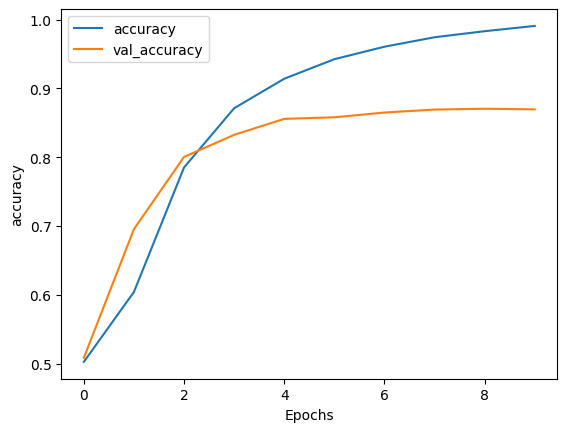

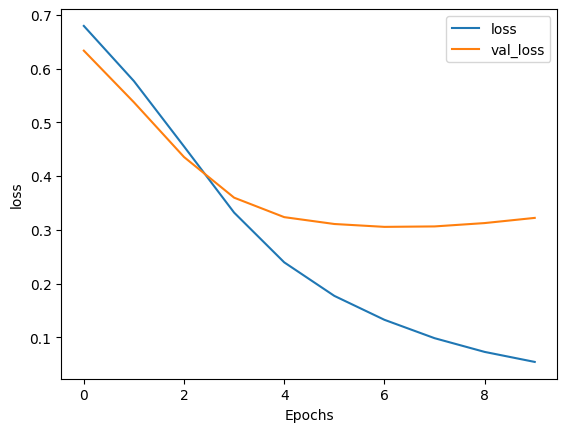

In [ ]:
plot_history(history, "accuracy")
plot_history(history, "loss")

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=2,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/2
30/30 [==============================] - 69s 2s/step - loss: 0.0402 - accuracy: 0.9945 - val_loss: 0.3331 - val_accuracy: 0.8706
Epoch 2/2
30/30 [==============================] - 47s 2s/step - loss: 0.0301 - accuracy: 0.9969 - val_loss: 0.3447 - val_accuracy: 0.8690


In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)
print("Results after training with best params, 2 epochs:")
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 13s - loss: 0.3732 - accuracy: 0.8515 - 13s/epoch - 274ms/step
Results after training with best params, 2 epochs:
loss: 0.373
accuracy: 0.852


## Avec split train/validation : 80%/20%

In [2]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import tf_keras as keras

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")


# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'train[80%:]', 'test'),
    as_supervised=True)


embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

#Construction du modèle
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Version:  2.17.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SYVLP6_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SYVLP6_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.SYVLP6_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#entrainement
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

#evaluation
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Epoch 1/10
40/40 [==============================] - 78s 2s/step - loss: 0.6385 - accuracy: 0.5408 - val_loss: 0.5677 - val_accuracy: 0.6328
Epoch 2/10
40/40 [==============================] - 58s 1s/step - loss: 0.4880 - accuracy: 0.7418 - val_loss: 0.4318 - val_accuracy: 0.7780
Epoch 3/10
40/40 [==============================] - 58s 1s/step - loss: 0.3444 - accuracy: 0.8540 - val_loss: 0.3495 - val_accuracy: 0.8546
Epoch 4/10
40/40 [==============================] - 59s 1s/step - loss: 0.2452 - accuracy: 0.9077 - val_loss: 0.3084 - val_accuracy: 0.8692
Epoch 5/10
40/40 [==============================] - 82s 2s/step - loss: 0.1774 - accuracy: 0.9368 - val_loss: 0.2936 - val_accuracy: 0.8738
Epoch 6/10
40/40 [==============================] - 70s 2s/step - loss: 0.1287 - accuracy: 0.9582 - val_loss: 0.3022 - val_accuracy: 0.8696
Epoch 7/10
40/40 [==============================] - 79s 2s/step - loss: 0.0985 - accuracy: 0.9686 - val_loss: 0.2989 - val_accuracy: 0.8776
Epoch 8/10
40/40 [==

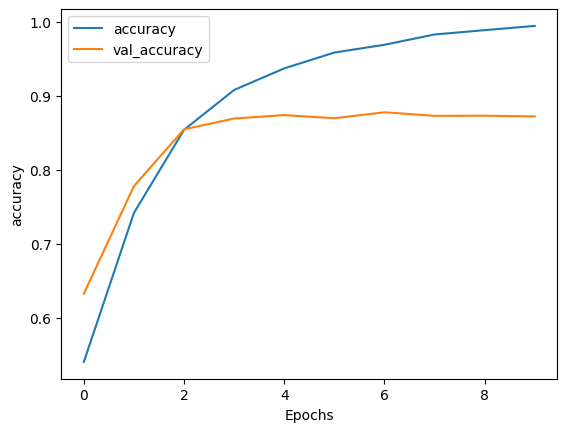

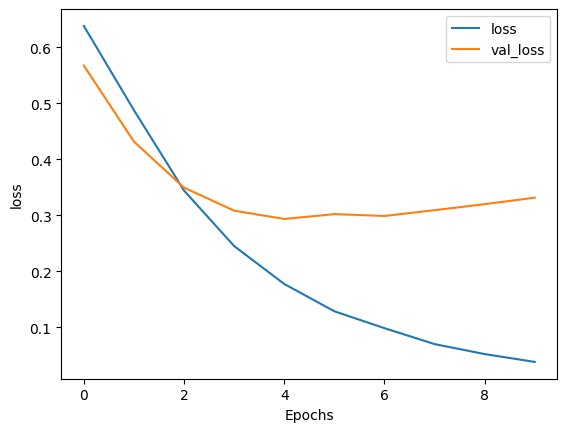

In [5]:
import matplotlib.pyplot as plt
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()


plot_history(history, "accuracy")
plot_history(history, "loss")

### Ajustement du nombre d'epochs

In [8]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

#Construction du modèle
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


####4 Epochs

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#entrainement
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=4,
                    validation_data=validation_data.batch(512),
                    verbose=1)

#evaluation
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Epoch 1/4
40/40 [==============================] - 62s 1s/step - loss: 0.6296 - accuracy: 0.5659 - val_loss: 0.5544 - val_accuracy: 0.6616
Epoch 2/4
40/40 [==============================] - 57s 1s/step - loss: 0.4686 - accuracy: 0.7528 - val_loss: 0.4130 - val_accuracy: 0.8070
Epoch 3/4
40/40 [==============================] - 57s 1s/step - loss: 0.3180 - accuracy: 0.8673 - val_loss: 0.3417 - val_accuracy: 0.8598
Epoch 4/4
40/40 [==============================] - 69s 2s/step - loss: 0.2258 - accuracy: 0.9133 - val_loss: 0.3093 - val_accuracy: 0.8622
49/49 - 10s - loss: 0.3211 - accuracy: 0.8520 - 10s/epoch - 209ms/step
loss: 0.321
accuracy: 0.852


####3 epochs

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
#entrainement
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=3,
                    validation_data=validation_data.batch(512),
                    verbose=1)

#evaluation
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("3 Epochs  - %s: %.3f" % (name, value))

Epoch 1/3
40/40 [==============================] - 65s 2s/step - loss: 0.6557 - accuracy: 0.5263 - val_loss: 0.5918 - val_accuracy: 0.6380
Epoch 2/3
40/40 [==============================] - 57s 1s/step - loss: 0.5075 - accuracy: 0.7395 - val_loss: 0.4425 - val_accuracy: 0.7868
Epoch 3/3
40/40 [==============================] - 78s 2s/step - loss: 0.3496 - accuracy: 0.8558 - val_loss: 0.3471 - val_accuracy: 0.8410
49/49 - 13s - loss: 0.3654 - accuracy: 0.8234 - 13s/epoch - 267ms/step
3 Epochs  - loss: 0.365
3 Epochs  - accuracy: 0.823


In [10]:

for name, value in zip(model.metrics_names, results):
  print(" %s: %.3f" % (name, value))

 loss: 0.365
 accuracy: 0.823
